In [1]:
CREDENTIALS = 'dsi-capstone-f19-group-1-d1fa043f65c5.json'
PROJECT_ID = 'dsi-capstone-f19-group-1'

In [2]:
import matplotlib.pyplot as plt
from google.cloud import bigquery
import networkx as nx

%load_ext google.cloud.bigquery
plt.style.use('fivethirtyeight')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import numpy as np 
from google.cloud import bigquery
from google.oauth2 import service_account

import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [67]:
import matplotlib.pylab as pylab

In [4]:
credentials = service_account.Credentials.from_service_account_file(CREDENTIALS)
project_id = PROJECT_ID
client = bigquery.Client(credentials= credentials,project=project_id)

In [5]:
%env GOOGLE_APPLICATION_CREDENTIALS = dsi-capstone-f19-group-1-d1fa043f65c5.json

env: GOOGLE_APPLICATION_CREDENTIALS=dsi-capstone-f19-group-1-d1fa043f65c5.json


In [6]:
%%bigquery tweets
SELECT DISTINCT full_text_cleaned AS full_text, id, id_str, created_at
FROM tweets.all_valid_tweets
WHERE ferguson_ht + michael_brown = 2 AND is_retweet = FALSE

In [7]:
tweets['date'] = tweets['created_at'].apply(lambda x: x.date())

In [8]:
tweets.head()

,full_text,id,id_str,created_at,date
0,michael and janet jackson scream hd 1080p offi...,500097476599115800,500097476599115778,2014-08-15 01:51:44+00:00,2014-08-15
1,it looks like theres way more people protestin...,501887965426356200,501887965426356224,2014-08-20 00:26:30+00:00,2014-08-20
2,yo go download my newsong malcomx anymeans rip...,505707481440329700,505707481440329729,2014-08-30 13:23:53+00:00,2014-08-30
3,why did you release the tape at the same time ...,500358689749229600,500358689749229568,2014-08-15 19:09:42+00:00,2014-08-15
4,drivers are stopping as they pass the site and...,500726049966407700,500726049966407680,2014-08-16 19:29:28+00:00,2014-08-16


In [9]:
%%bigquery df_topics
SELECT *
FROM topic_modeling.topics_ferguson_brown

In [10]:
df_topics['full_text'] = df_topics['Text']
df_topics = df_topics.drop(['Text'], axis=1)

In [96]:
merged_df = pd.merge(df_topics, tweets, on='id')
merged_df['full_text'] = merged_df['full_text_x']
merged_df= merged_df.drop(['full_text_y','full_text_x'],axis=1)

In [12]:
#Change the dataframe to have each score as a separate column

sid = SentimentIntensityAnalyzer()
merged_df["sentiments"] = merged_df["full_text"].apply(lambda x: sid.polarity_scores(x))
merged_df = pd.concat([merged_df.drop(['sentiments'], axis=1), merged_df['sentiments'].apply(pd.Series)], axis=1)
merged_df_2 = merged_df.copy()

Text(0.5, 1.0, 'Distribution of Compound Score of All Tweets')

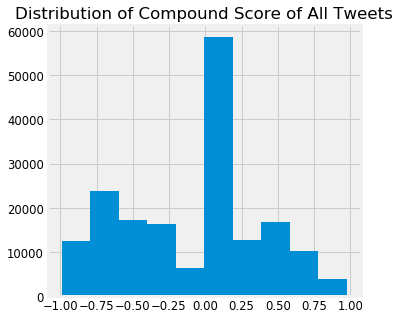

In [89]:
params = {'legend.fontsize': 'x-small',
#           'figure.figsize': (15, 5),
         'axes.labelsize': 'small',
         'axes.titlesize':'small',
         'xtick.labelsize':'xx-small',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)

merged_df_2.hist(column='compound', figsize=(5,5))
plt.title('Distribution of Compound Score of All Tweets')

## Distribution of compound score of tweets per topic

In [16]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', -1)
    #print(x)
    return(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3f0d8320>,
      dtype=object)

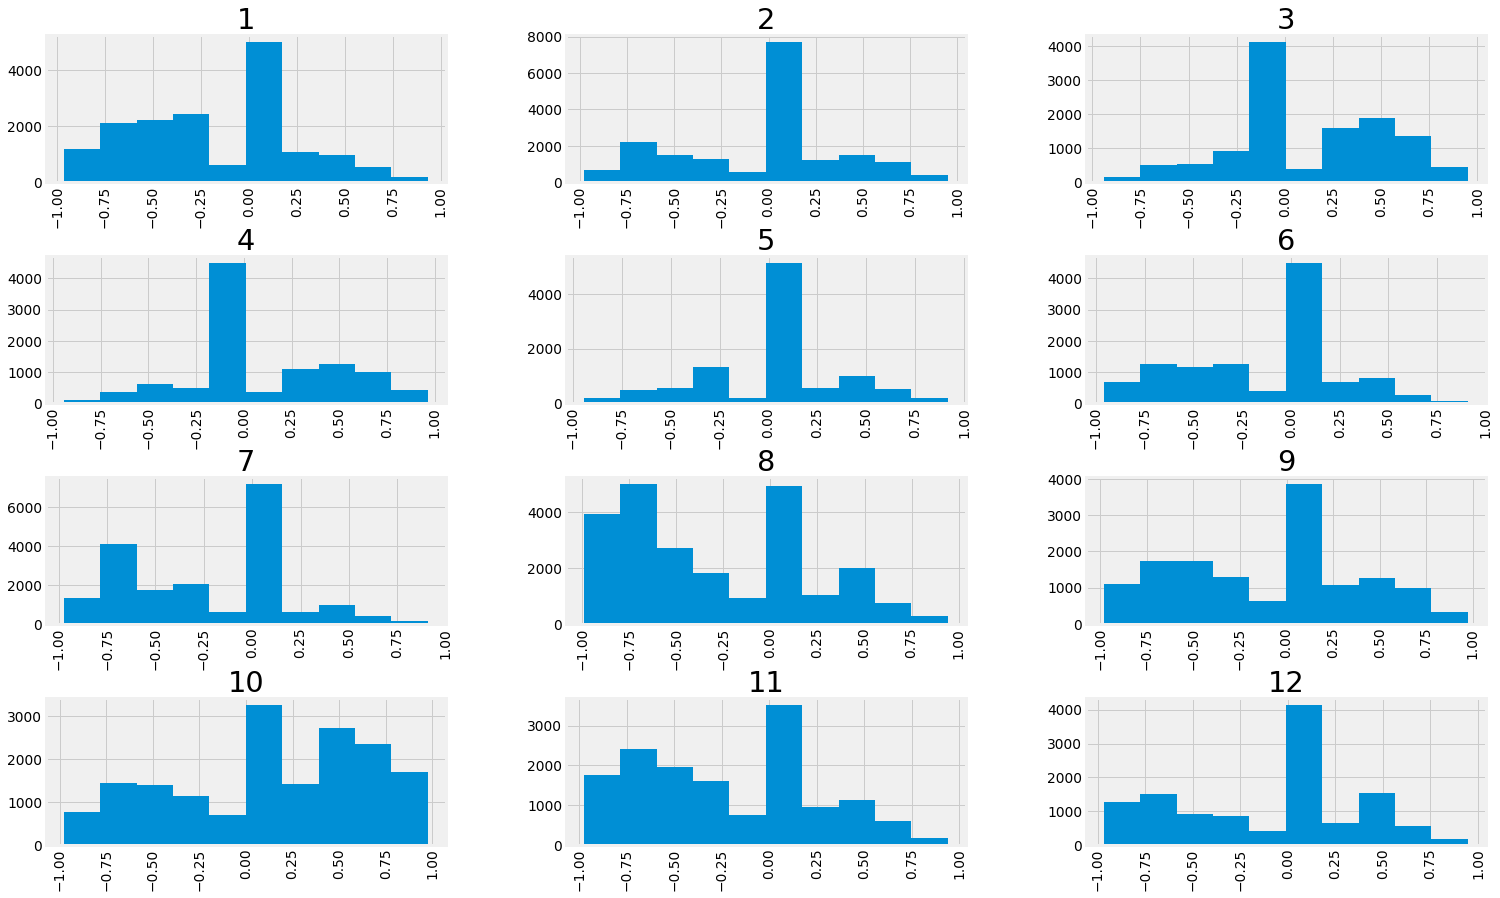

In [77]:
merged_df_2['compound'].hist(by=merged_df_2['Dominant_Topic'], figsize=(25,15))


## Time series of  sentiment scores of tweets per day per topic

In [18]:
sentiments_df = merged_df.copy()
pivoted_df = pd.pivot_table(sentiments_df, index= 'date', columns= 'Dominant_Topic', values= "compound")

Text(0, 0.5, 'compound score')

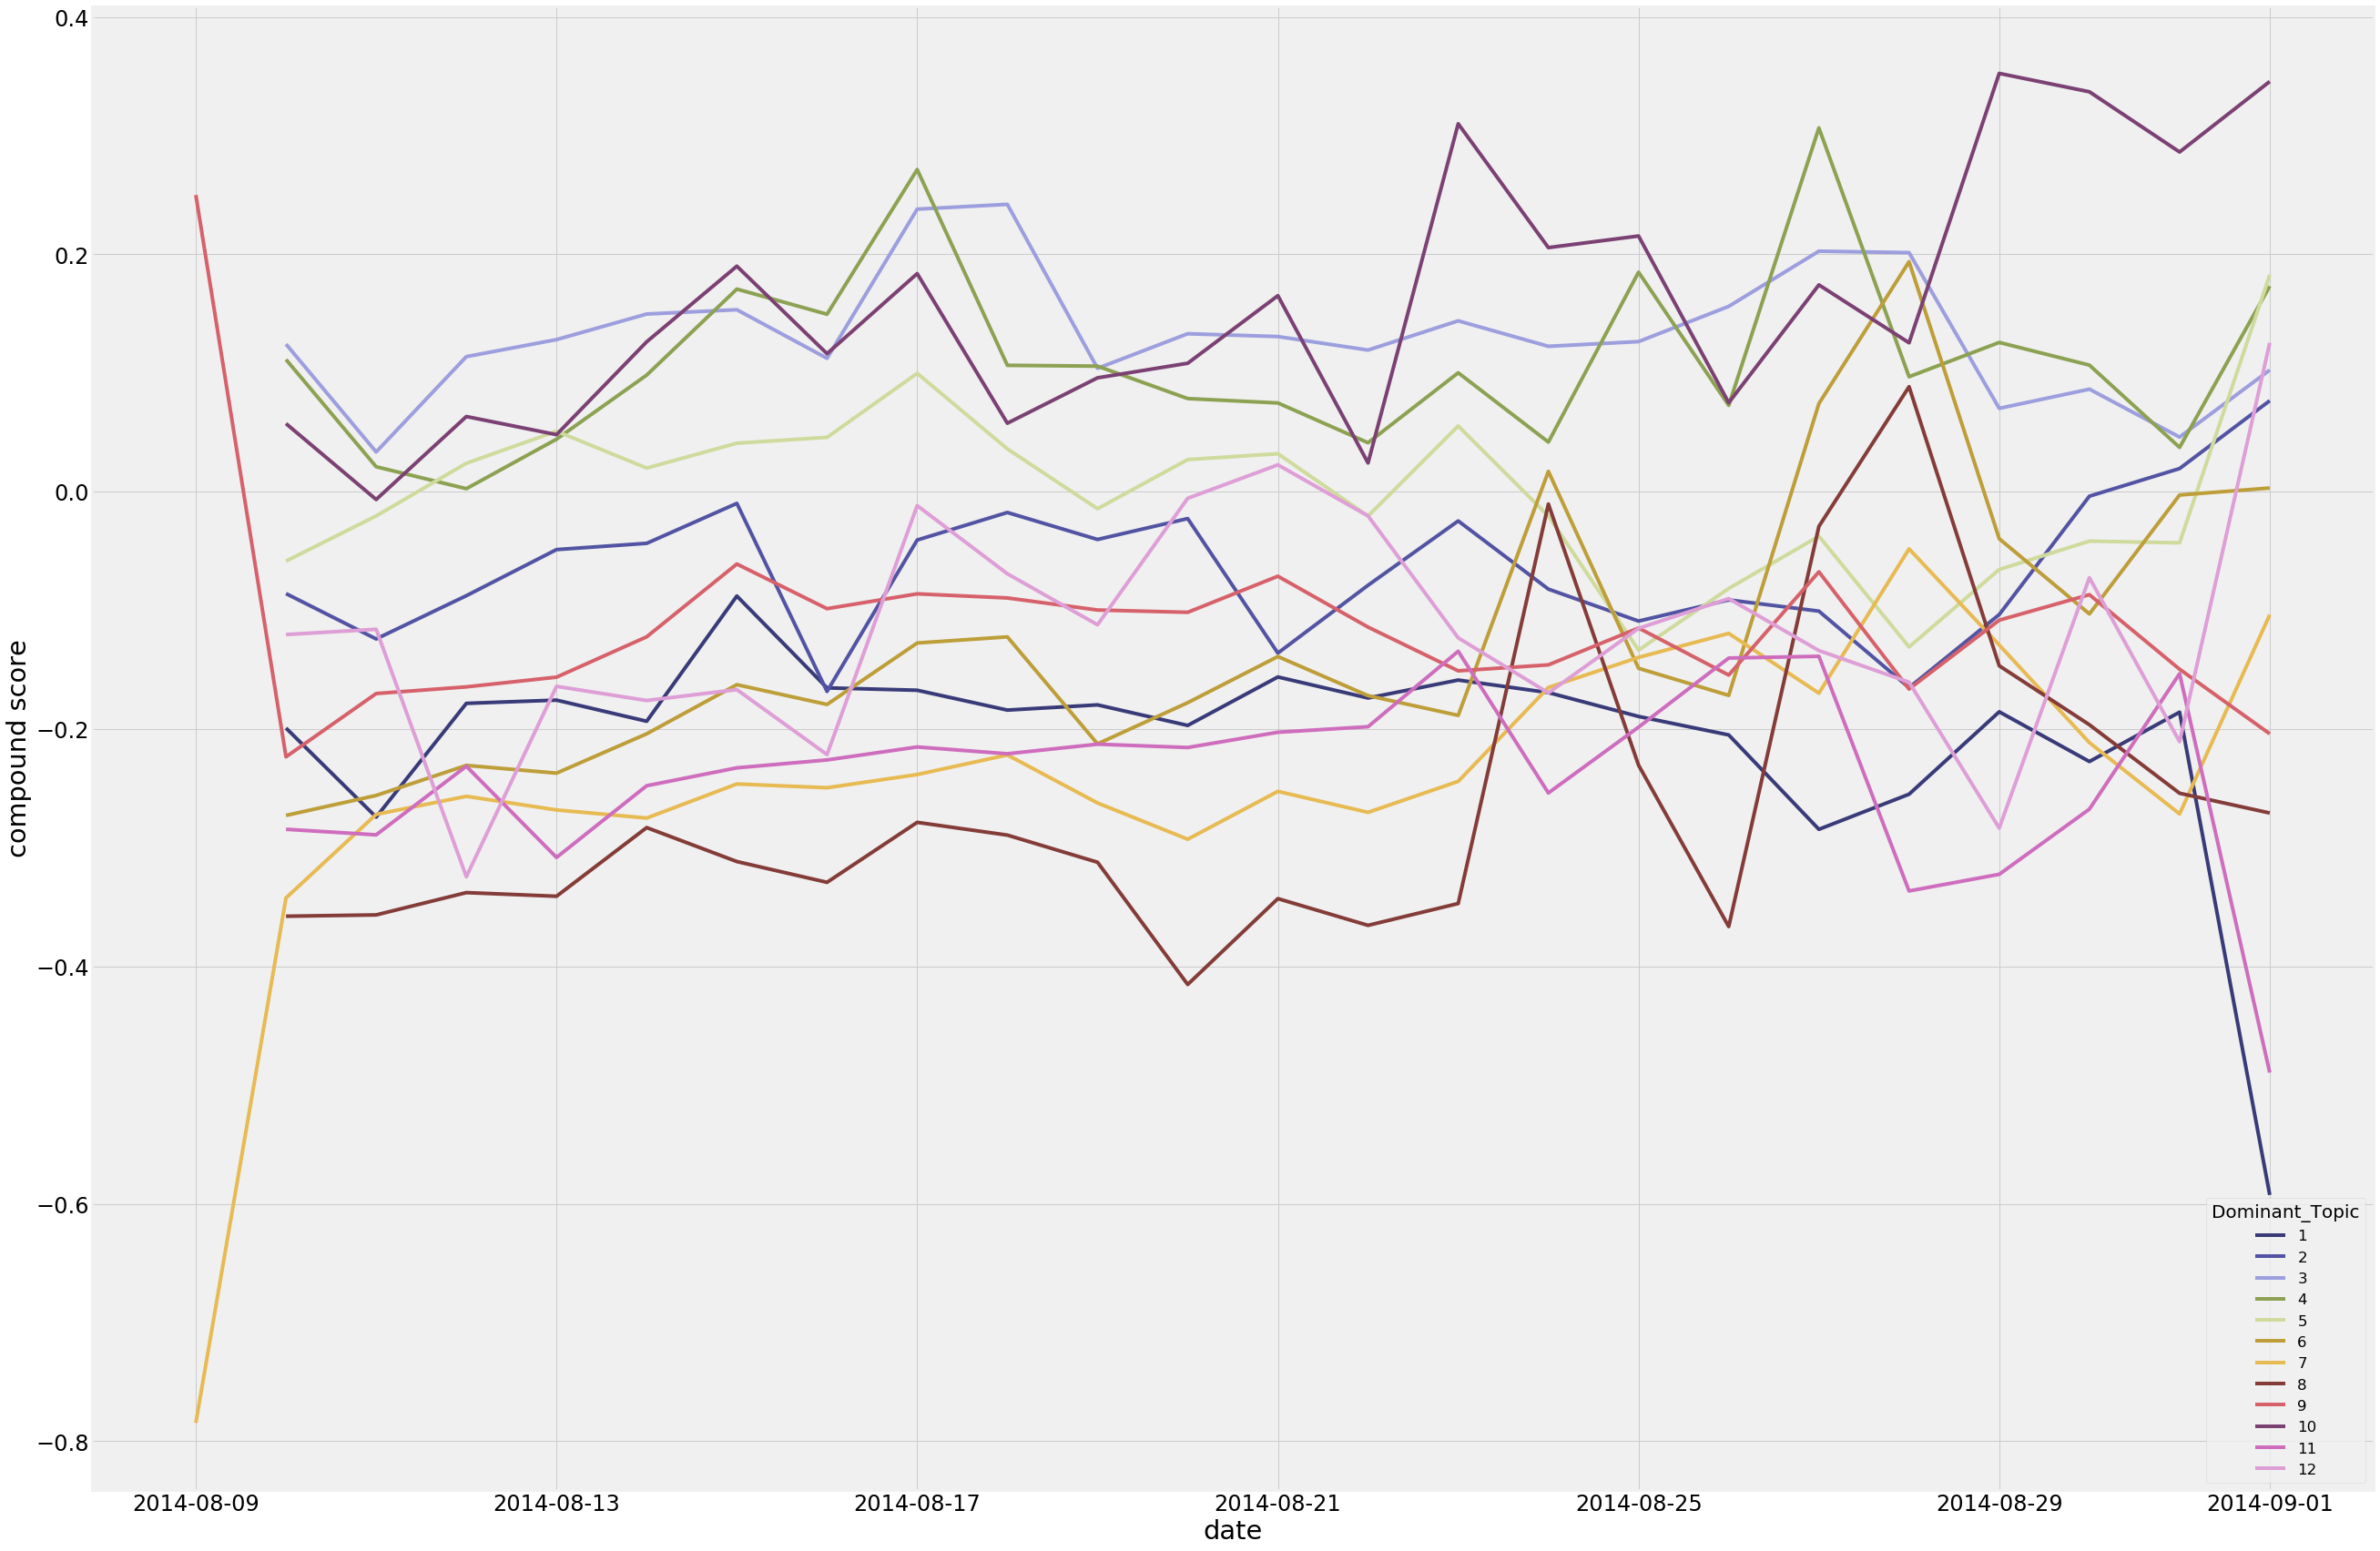

In [94]:
params = {'legend.fontsize': 'small',
#           'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
pivoted_df.plot(figsize=(40,30), colormap='tab20b', grid=True)
plt.ylabel("compound score")


Text(0, 0.5, 'compound score')

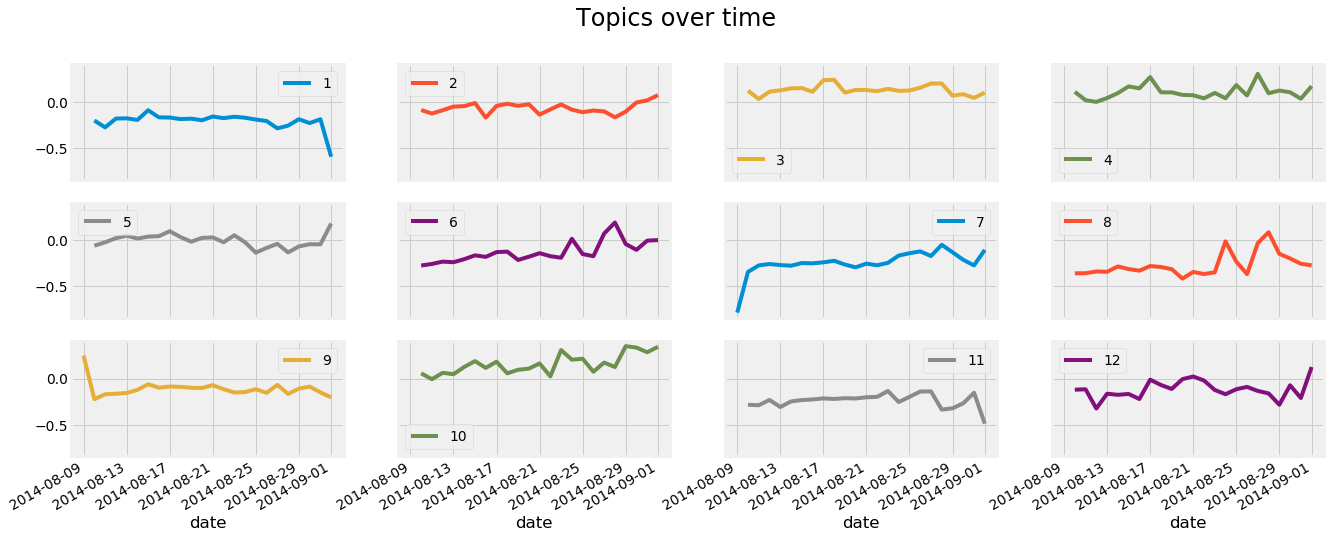

In [95]:
params = {'legend.fontsize': 'x-small',
#           'figure.figsize': (15, 5),
         'axes.labelsize': 'small',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-small',
         'ytick.labelsize':'x-small'}
pylab.rcParams.update(params)
pivoted_df.plot(subplots=True,figsize=(20,8), sharey=True, grid=True, layout=(3,4), title = 'Topics over time')
plt.ylabel("compound score")


## Time series of sentiment scores

Note:

   Pos, Neg, neu are proportion of text that falls in each category

   Compound is a score between [-1, 1]

In [22]:
sentiments_df = sentiments_df.drop(['id','Topic_Perc_Contrib'],axis=1)
sentiments_df_by_day = sentiments_df.groupby(sentiments_df.created_at.dt.date).mean()
sentiments_df_scores_by_day = sentiments_df_by_day.drop('Dominant_Topic', axis = 1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a3f1ab240>,
      dtype=object)

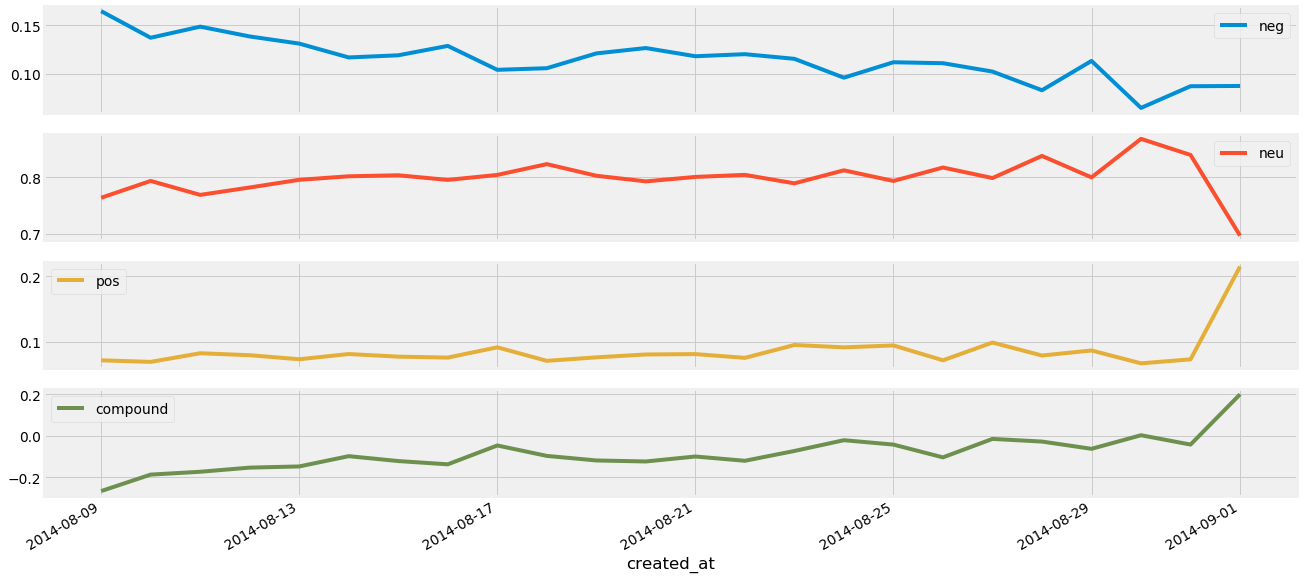

In [76]:
sentiments_df_scores_by_day.plot(figsize=(20,10), subplots=True)